## Import packages

In [150]:
import pandas as pd
import tushare as ts
import numpy as np
import matplotlib.pyplot as plt

## Import data

In [151]:
pro = ts.pro_api('ENTER YOUR TOKEN HERE.')

stk_id = '002291.SZ'
df = pro.daily(ts_code=stk_id, start_date='20110101', end_date='20211231')
df.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,002291.SZ,20211231,20.39,20.57,19.80,19.96,20.19,-0.23,-1.1392,166621.66,335157.847
1,002291.SZ,20211230,19.62,20.36,19.50,20.19,19.60,0.59,3.0102,159408.17,318711.929
2,002291.SZ,20211229,19.72,20.24,19.31,19.60,19.82,-0.22,-1.1100,137971.70,272199.528
3,002291.SZ,20211228,20.01,20.10,19.55,19.82,19.91,-0.09,-0.4520,114184.43,226190.658
4,002291.SZ,20211227,20.49,20.50,19.70,19.91,20.52,-0.61,-2.9727,182761.13,364088.077


In [152]:
data = df.reindex(index=df.index[::-1])

In [153]:
data['trade_date'] = data['trade_date'].str[:4]+'-'+data['trade_date'].str[4:6]+'-'+data['trade_date'].str[6:]
data.set_index('trade_date', inplace=True)

## Construct strategy

### Compute MACD and Signal lines

>> 当 MACD线值 > 信号线值时        
>> 说明发生了金叉，此时看涨，买入。         

>> 当MACD线 < 信号线时，卖出

When **the value of the MACD line < the value of the signal line**                 
indicates that a golden cross has occurred, at this time it is bullish, and **we bought this stock**.

Sell in the **reverse scenario**.

All the transactions will have one day lag, since once we notice the signal, we will trade next day.

In [154]:
EMA1 = 12
EMA2 = 26
EMA3 = 9

data['EMA1'] = data['close'].ewm(span=EMA1,min_periods=0, adjust=False, ignore_na=False).mean()
data['EMA2'] = data['close'].ewm(span=EMA2,min_periods=0, adjust=False, ignore_na=False).mean()
data['MACD'] = data['EMA1']-data['EMA2']
data['Signal'] = data['MACD'].ewm(span=EMA3,min_periods=0, adjust=False, ignore_na=False).mean() 

# data['MACD-Signal'] = data['MACD']-data['Signal']
data.head()

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,EMA1,EMA2,MACD,Signal
trade_date,,,,,,,,,,,,,,
2011-01-04,002291.SZ,19.22,19.26,18.90,19.10,19.21,-0.11,-0.57,7463.24,14225.1054,19.100000,19.100000,0.000000,0.000000
2011-01-05,002291.SZ,19.03,19.08,18.60,18.92,19.10,-0.18,-0.94,5876.58,11057.4652,19.072308,19.086667,-0.014359,-0.002872
2011-01-06,002291.SZ,18.93,18.96,18.50,18.77,18.92,-0.15,-0.79,5774.49,10806.2752,19.025799,19.063210,-0.037411,-0.009780
2011-01-07,002291.SZ,18.58,18.90,18.58,18.80,18.77,0.03,0.16,3710.26,6958.7684,18.991061,19.043713,-0.052652,-0.018354
2011-01-10,002291.SZ,18.84,18.85,18.15,18.20,18.80,-0.60,-3.19,5964.96,10998.9574,18.869359,18.981216,-0.111857,-0.037055


### Determine position

In [155]:
long_list = []
short_list = []
signal = np.nan

for i in range(data.__len__()):
    # Long signal
    if data.iloc[i]['MACD'] < data.iloc[i]['Signal']:
        short_list.append(np.nan)
        if signal != 1:
            signal = 1
            long_list.append(data.iloc[i]['close'])
        else:
            long_list.append(np.nan)
            
    # Short signal
    elif data.iloc[i]['MACD'] > data.iloc[i]['Signal']:
        long_list.append(np.nan)
        if signal != -1:
            signal = -1
            short_list.append(data.iloc[i]['close'])
        else:
            short_list.append(np.nan)
            
    # No signal
    else:
        short_list.append(np.nan)
        long_list.append(np.nan)

In [156]:
data['long_price'] = short_list
data['short_price'] = long_list
data.head()

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,EMA1,EMA2,MACD,Signal,long_price,short_price
trade_date,,,,,,,,,,,,,,,,
2011-01-04,002291.SZ,19.22,19.26,18.90,19.10,19.21,-0.11,-0.57,7463.24,14225.1054,19.100000,19.100000,0.000000,0.000000,NaN,NaN
2011-01-05,002291.SZ,19.03,19.08,18.60,18.92,19.10,-0.18,-0.94,5876.58,11057.4652,19.072308,19.086667,-0.014359,-0.002872,NaN,18.92
2011-01-06,002291.SZ,18.93,18.96,18.50,18.77,18.92,-0.15,-0.79,5774.49,10806.2752,19.025799,19.063210,-0.037411,-0.009780,NaN,NaN
2011-01-07,002291.SZ,18.58,18.90,18.58,18.80,18.77,0.03,0.16,3710.26,6958.7684,18.991061,19.043713,-0.052652,-0.018354,NaN,NaN
2011-01-10,002291.SZ,18.84,18.85,18.15,18.20,18.80,-0.60,-3.19,5964.96,10998.9574,18.869359,18.981216,-0.111857,-0.037055,NaN,NaN


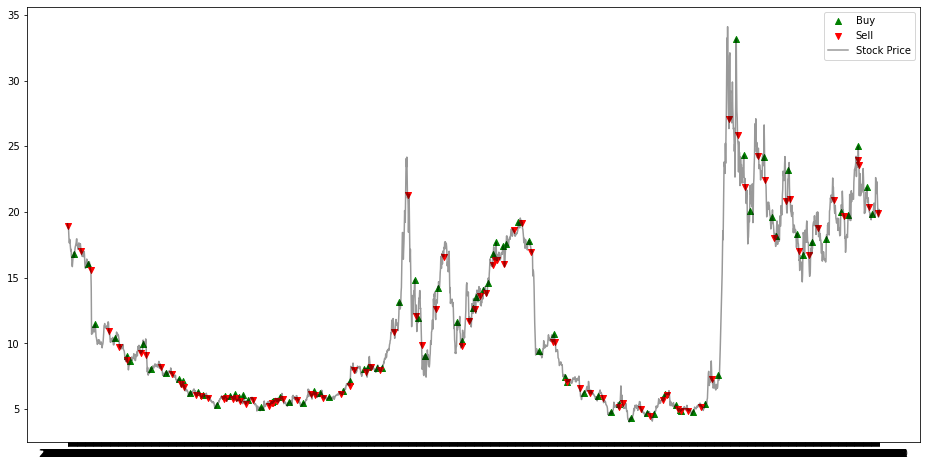

In [157]:
fig = plt.figure(figsize=(16,8))
plt.scatter(data.index, data['long_price'], color='green', label='Buy', marker='^')
plt.scatter(data.index, data['short_price'], color='red', label='Sell', marker='v')
plt.plot(data['close'], label='Stock Price', color = 'black', alpha=0.4)
plt.legend()
plt.show()

## Backtesting

Calculate strategy returns and the correponding drawdown.

Here I use the stock itself as the benchmark (not rigorous enough), and we buy the benchmark at the very begining (starting point), and sell at the end of the backtesting period, to see its returns and drawdown.

In [158]:
data['returns'] = data['close']/data['close'].shift(1)

In [159]:
data['long'] = np.where(np.isnan(data['long_price'])==False, 1, np.nan)
# data['short'] = np.where(np.isnan(data['short_price'])==False, 1, np.nan)
data['strategy_return'] = np.where(data['long'].shift(1)==1, data.returns, 1)

data.head()

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,EMA1,EMA2,MACD,Signal,long_price,short_price,returns,long,strategy_return
trade_date,,,,,,,,,,,,,,,,,,,
2011-01-04,002291.SZ,19.22,19.26,18.90,19.10,19.21,-0.11,-0.57,7463.24,14225.1054,19.100000,19.100000,0.000000,0.000000,NaN,NaN,NaN,NaN,1.0
2011-01-05,002291.SZ,19.03,19.08,18.60,18.92,19.10,-0.18,-0.94,5876.58,11057.4652,19.072308,19.086667,-0.014359,-0.002872,NaN,18.92,0.990576,NaN,1.0
2011-01-06,002291.SZ,18.93,18.96,18.50,18.77,18.92,-0.15,-0.79,5774.49,10806.2752,19.025799,19.063210,-0.037411,-0.009780,NaN,NaN,0.992072,NaN,1.0
2011-01-07,002291.SZ,18.58,18.90,18.58,18.80,18.77,0.03,0.16,3710.26,6958.7684,18.991061,19.043713,-0.052652,-0.018354,NaN,NaN,1.001598,NaN,1.0
2011-01-10,002291.SZ,18.84,18.85,18.15,18.20,18.80,-0.60,-3.19,5964.96,10998.9574,18.869359,18.981216,-0.111857,-0.037055,NaN,NaN,0.968085,NaN,1.0


In [160]:
start_balance = 10000
data['balance'] = start_balance*data.strategy_return.cumprod()
data['peak'] = data.balance.cummax()
data['drawdown'] = data['balance']-data['peak']

data.head()

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,...,MACD,Signal,long_price,short_price,returns,long,strategy_return,balance,peak,drawdown
trade_date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,002291.SZ,19.22,19.26,18.90,19.10,19.21,-0.11,-0.57,7463.24,14225.1054,...,0.000000,0.000000,NaN,NaN,NaN,NaN,1.0,10000.0,10000.0,0.0
2011-01-05,002291.SZ,19.03,19.08,18.60,18.92,19.10,-0.18,-0.94,5876.58,11057.4652,...,-0.014359,-0.002872,NaN,18.92,0.990576,NaN,1.0,10000.0,10000.0,0.0
2011-01-06,002291.SZ,18.93,18.96,18.50,18.77,18.92,-0.15,-0.79,5774.49,10806.2752,...,-0.037411,-0.009780,NaN,NaN,0.992072,NaN,1.0,10000.0,10000.0,0.0
2011-01-07,002291.SZ,18.58,18.90,18.58,18.80,18.77,0.03,0.16,3710.26,6958.7684,...,-0.052652,-0.018354,NaN,NaN,1.001598,NaN,1.0,10000.0,10000.0,0.0
2011-01-10,002291.SZ,18.84,18.85,18.15,18.20,18.80,-0.60,-3.19,5964.96,10998.9574,...,-0.111857,-0.037055,NaN,NaN,0.968085,NaN,1.0,10000.0,10000.0,0.0


In [161]:
# Benchmark return and drawdown
data['bench_balance'] = start_balance*data.returns.cumprod()
data['bench_peak'] = data.bench_balance.cummax()
data['bench_drawdown'] = data['bench_balance']-data['bench_peak']

### Report result

In [162]:
bench_return = data.bench_balance[-1]/data.bench_balance[1]-1
bench_dd = (data.bench_drawdown/data.bench_peak).min()

strategy_return = data.balance[-1]/data.balance[0]-1
strategy_dd = (data.drawdown/data.peak).min()

print(f'The benchmark return is {round(bench_return*100, 2)}%.')
print(f'The benchmark drawdown is {round(bench_dd*100, 2)}%.')
print('----------------------------------------------------------')
print(f'The strategy return is {round(strategy_return*100, 2)}%.')
print(f'The strategy drawdown is {round(strategy_dd*100, 2)}%.')

The benchmark return is 5.5%.
The benchmark drawdown is -83.45%.
----------------------------------------------------------
The strategy return is 16.28%.
The strategy drawdown is -17.96%.
